# Manifold reconstruction of synthetic Lorenz signal

In [1]:
import numpy as np
import mne
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from statsmodels.tsa.stattools import acf

from stochastic_dynamics.generators import lorenz
from stochastic_dynamics.models import AR, TAR
from stochastic_dynamics.embedders import embed
from stochastic_dynamics.pub_utils import *

set_pub_style()

In [2]:
xs, ys, zs = lorenz(T_steps=40000, 
                    dt=0.005, 
                    sigma=10.0, 
                    rho=28.0, 
                    beta=8/3, 
                    x0=(1.0, 1.0, 1.0))

fs = 1.0 / 0.005
burn = 2000  # drop transient
data_psd = np.vstack([xs[burn:], ys[burn:], zs[burn:]])  #(3, n_times)

In [3]:
# compute PSD for all three channels 
psds, freqs = mne.time_frequency.psd_array_welch(
    data_psd,
    sfreq=fs,
    fmin=0.1, fmax=10,
    n_fft=4096,
    n_overlap=2048,
    average='mean'
)

# smooth each PSD along frequency axis
Pxx_smooth = gaussian_filter1d(psds[0], sigma=2)
Pyy_smooth = gaussian_filter1d(psds[1], sigma=2)
Pzz_smooth = gaussian_filter1d(psds[2], sigma=2)

Effective window size : 20.480 (s)


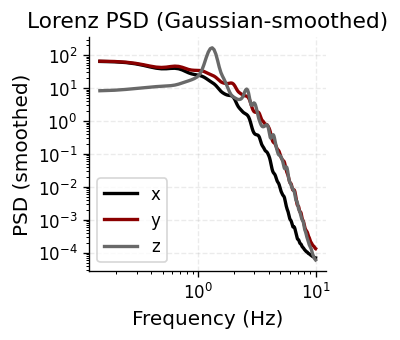

In [4]:
plt.figure(figsize=(3,3))
plt.loglog(freqs, Pxx_smooth, 'k', lw=2, label="x")
plt.loglog(freqs, Pyy_smooth, 'darkred', lw=2, label="y")
plt.loglog(freqs, Pzz_smooth, 'dimgray', lw=2, label="z")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (smoothed)")
plt.title("Lorenz PSD (Gaussian-smoothed)")
plt.grid(True, ls="--", alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
p_list = list(range(2, 7))
mse_te_list, aic_list, bic_list = [], [], []
params_by_p = {}
splits = {}

for p in p_list:
    X, y = AR.lag_matrix(xs, p)
    N = len(y)
    ntr = int(0.8 * N)
    X_tr, y_tr = X[:ntr], y[:ntr]
    X_te, y_te = X[ntr:], y[ntr:]
    w = AR.ols_with_intercept(X_tr, y_tr)
    yhat_tr = AR.predict_from_params(X_tr, w)
    yhat_te = AR.predict_from_params(X_te, w)
    mse_te, _, _ = AR.metrics(y_te, yhat_te)
    aic, bic = AR.aic_bic(y_tr, yhat_tr, k=p+1)
    mse_te_list.append(mse_te); aic_list.append(aic); bic_list.append(bic)
    params_by_p[p] = w
    splits[p] = (ntr, y, yhat_tr, yhat_te)

best_p_by_mse = p_list[int(np.argmin(mse_te_list))]
best_p_by_bic = p_list[int(np.argmin(bic_list))]

best_p_by_mse = 3
best_p_by_bic = 3

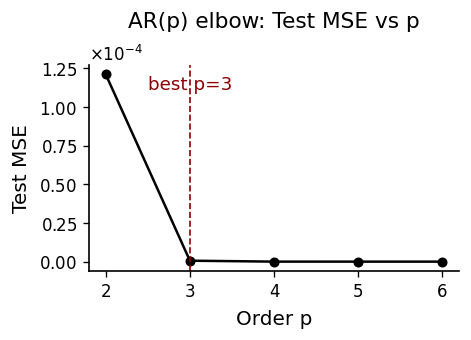

In [6]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(p_list, mse_te_list, marker='o', color=color_main, lw=1.5, ms=5)
ax.axvline(best_p_by_mse, linestyle='--', color=color_alt, linewidth=1)
ax.text(best_p_by_mse, ax.get_ylim()[1]*0.95, f"best p={best_p_by_mse}",
        ha='center', va='top', color=color_alt, fontsize=11)

sf = ScalarFormatter(useMathText=True)
sf.set_powerlimits((-3, 3))   # switch to sci notation outside this range
ax.yaxis.set_major_formatter(sf)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
ax.yaxis.get_offset_text().set_size(10)  # the “×10^−4” offset text
prettify(ax, title="AR(p) elbow: Test MSE vs p", xlabel="Order p", ylabel="Test MSE")
plt.tight_layout(); plt.show()

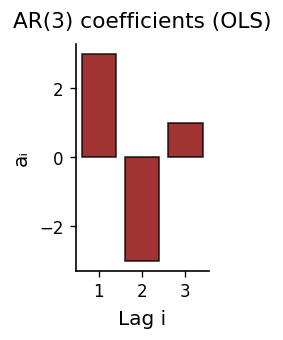

In [7]:
p_use = best_p_by_bic
w = params_by_p[p_use]
fig, ax = plt.subplots(figsize=(2,3))
bars = ax.bar(np.arange(1, p_use+1), w[1:], color=color_alt, edgecolor=color_main, alpha=0.8)
prettify(ax, title=f"AR({p_use}) coefficients (OLS)", xlabel="Lag i", ylabel="aᵢ")
plt.tight_layout(); plt.show()

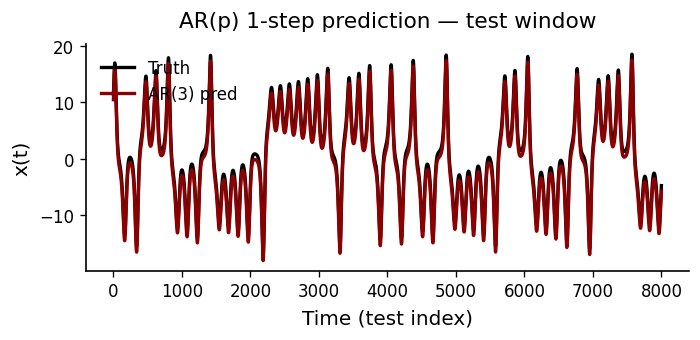

In [8]:
ntr, y_all, yhat_tr, yhat_te = splits[p_use]
X, y = AR.lag_matrix(xs, p_use)
fig, ax = plt.subplots(figsize=(6,3))
win = slice(ntr, min(ntr+1500, len(y)))
win = slice(ntr, len(y))   # all available test samples

ax.plot(y[win]+1, color=color_main, lw=2, label="Truth")
ax.plot(yhat_te[:win.stop-win.start], color=color_alt, lw=2, label=f"AR({p_use}) pred")
prettify(ax, title="AR(p) 1-step prediction — test window", 
         xlabel="Time (test index)", ylabel="x(t)", add_legend=True)
plt.tight_layout(); plt.show()

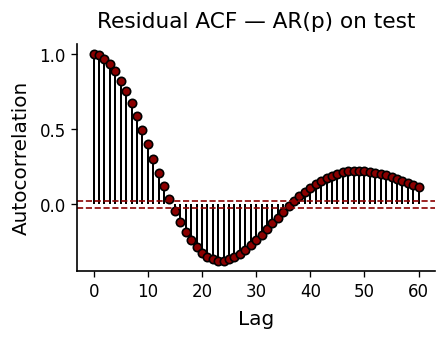

In [9]:
resid_te = y[ntr:] - yhat_te
acf_vals = acf(resid_te, nlags=60)
N_te = len(resid_te)
bound = 1.96 / np.sqrt(max(N_te,1))

fig, ax = plt.subplots(figsize=(4,3))
markerline, stemlines, baseline = ax.stem(range(len(acf_vals)), acf_vals, basefmt=" ")

# Customize stem plot colors
plt.setp(stemlines, color=color_main, linewidth=1.2)
plt.setp(markerline, marker='o', markersize=5,
         markeredgecolor=color_main, markerfacecolor=color_alt)

# Add confidence bounds
ax.axhline(bound, linestyle='--', color=color_alt, linewidth=1)
ax.axhline(-bound, linestyle='--', color=color_alt, linewidth=1)

prettify(ax, title="Residual ACF — AR(p) on test", xlabel="Lag", ylabel="Autocorrelation")
plt.tight_layout()
plt.show()

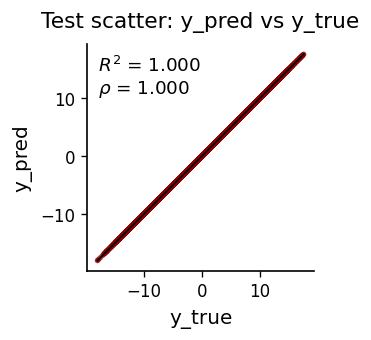

In [10]:
y_true = y[ntr:]
y_pred = yhat_te
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(y_true, y_pred, c=color_alt, alpha=0.35, s=10, edgecolors="none")
# identity line
vmin = min(np.min(y_true), np.min(y_pred))
vmax = max(np.max(y_true), np.max(y_pred))
ax.plot([vmin, vmax], [vmin, vmax], color=color_main, lw=1)

# R² and corr
yt = y_true - np.mean(y_true)
yp = y_pred - np.mean(y_pred)
corr = float((yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp) + 1e-12))
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r2 = 1 - ss_res / (ss_tot + 1e-12)
ax.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\n$\\rho$ = {corr:.3f}",
        transform=ax.transAxes, ha='left', va='top', fontsize=11,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round"))

ax.set_aspect('equal', adjustable='box')
prettify(ax, title="Test scatter: y_pred vs y_true", xlabel="y_true", ylabel="y_pred")
plt.tight_layout(); plt.show()

In [13]:
xs, ys, zs = lorenz(T_steps=12000)

# Fit TAR
tar = TAR.fit(xs, p=8, d=1, thresh=0.0, train_frac=0.8)
p_use, d_use = tar["p"], tar["d"]
ntr = tar["ntr"]
true_test = tar["y_all"][ntr:]
t_x_start_test = p_use + ntr
init = [xs[t_x_start_test - i] for i in range(1, p_use+1)]
n_steps = len(true_test)

# Simulate TAR with bootstrap residuals and variance matching to the test slice
x_tar = TAR.simulate_tar_free_run(tar, 
                                  init_lags=init, 
                                  n_steps=n_steps, 
                                  seed=42, 
                                  variance_match_to=true_test)

# Embeddings with τ=15
tau = 15
X3_true = embed(true_test, m=3, tau=tau)
X3_tar  = embed(x_tar, m=3, tau=tau)

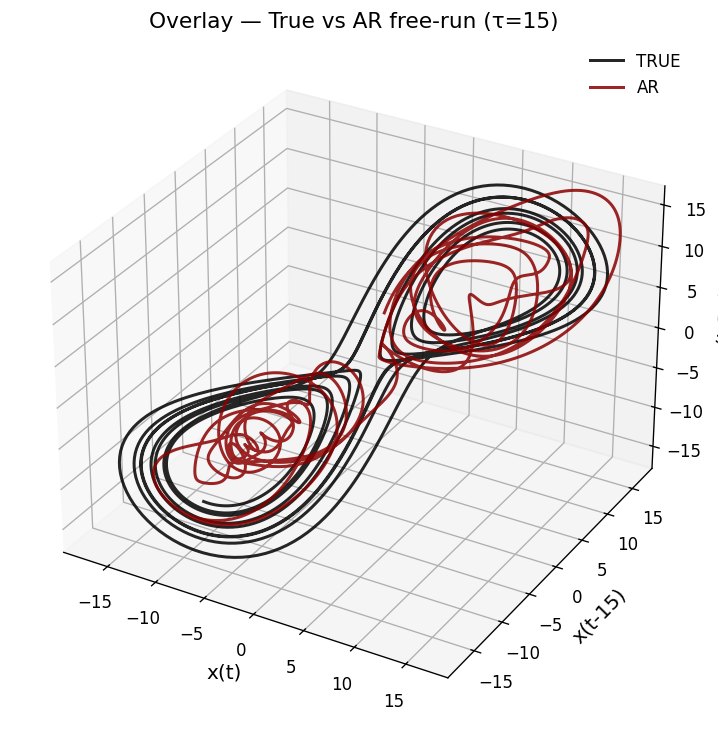

In [14]:
# Overlay
n_overlay = min(len(X3_true), len(X3_tar))
X3_true_m = X3_true[:n_overlay]
X3_tar_m  = X3_tar[:n_overlay]

plt.rcParams.update({
    "figure.dpi": 120, "font.size": 12,
    "axes.spines.top": False, "axes.spines.right": False,
    "axes.grid": True, "grid.alpha": 0.25
})

fig = plt.figure(figsize=(8,6), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

ax.plot(X3_true_m[:,0], X3_true_m[:,1], X3_true_m[:,2], color = 'black',label="TRUE", alpha=0.85)
ax.plot(X3_tar_m[:,0],  X3_tar_m[:,1],  X3_tar_m[:,2],  color = 'darkred',label="AR", alpha=0.85)
ax.set_title(f"Overlay — True vs AR free-run (τ={tau})")
ax.set_xlabel("x(t)"); ax.set_ylabel(f"x(t-{tau})"); ax.set_zlabel(f"x(t-{2*tau})")

ax.legend(frameon=False)
plt.show()